# Assignment: Video Quality Inference

To this point in the class, you have learned various techniques for leading and analyzing packet captures of various types, generating features from those packet captures, and training and evaluating models using those features.

In this assignment, you will put all of this together, using a network traffic trace to train a model to automatically infer video quality of experience from a labeled traffic trace.

## Part 1: Warmup

The first part of this assignment builds directly on the hands-on activities but extends them slightly.

### Extract Features from the Network Traffic

Load the `netflix.pcap` file, which is a packet trace that includes network traffic. 

Click [here](https://github.com/noise-lab/ml-systems/blob/main/docs/notebooks/data/netflix.pcap) to download `netflix.pcap`.


Acknowledgements:

I used claude AI for multiple purposes throughout this. The main use was to make my notebook much neater, add comment to code, add headers and print statements to my outputs for each block. I also used it to help in cleaning up of data. After deciding on which columns to cut I asked it to cut them. I also used it to debug why I was not initially getting IP addresses when manually trying to extract them.

In [67]:
from scapy.all import rdpcap, wrpcap, DNS, DNSQR, DNSRR, IP, TCP
import pandas as pd
import numpy as np
# Load the packet capture
pcap_file = 'netflix.pcap'
packets = rdpcap(pcap_file)

print(f"Loaded {len(packets)} packets")
print(f"Duration: {packets[-1].time - packets[0].time:.2f} seconds")

Loaded 141471 packets
Duration: 495.78 seconds


### Identifying the Service Type

Use the DNS traffic to filter the packet trace for Netflix traffic.

In [68]:
from collections import defaultdict

print("\n" + "="*80)
print("finding netflix traffic...")
print("="*80)

# look for netflix domains in DNS queries
netflix_queries = set()

for pkt in packets:
    if pkt.haslayer(DNS) and pkt.haslayer(DNSQR):
        query = pkt[DNSQR].qname.decode('utf-8', errors='ignore').lower()
        if 'netflix' in query or 'nflx' in query:
            netflix_queries.add(query)

print(f"\nfound {len(netflix_queries)} netflix domains:")
for domain in sorted(netflix_queries):
    print(f"  - {domain}")

# get IPs from DNS responses
netflix_ips = set()

for pkt in packets:
    if pkt.haslayer(DNS):
        if pkt[DNS].qr == 1:  # response
            if pkt.haslayer(DNSQR):
                query = pkt[DNSQR].qname.decode('utf-8', errors='ignore').lower()
                
                if query in netflix_queries:
                    if pkt.haslayer(DNSRR) and pkt[DNS].ancount > 0:
                        for i in range(pkt[DNS].ancount):
                            try:
                                answer = pkt[DNSRR][i]
                                if answer.type == 1:  # IPv4
                                    ip = answer.rdata
                                    netflix_ips.add(ip)
                            except:
                                pass

print(f"\nnetflix IPs from DNS: {len(netflix_ips)}")

# if no DNS responses, use traffic patterns instead
if len(netflix_ips) == 0:
    print("\nno DNS responses found, analyzing traffic patterns...\n")
    
    # count bytes per IP
    ip_stats = defaultdict(lambda: {'bytes': 0, 'packets': 0, 'ports': set()})
    
    for pkt in packets:
        if pkt.haslayer(IP):
            src_ip = pkt[IP].src
            dst_ip = pkt[IP].dst
            
            ip_stats[src_ip]['bytes'] += len(pkt)
            ip_stats[src_ip]['packets'] += 1
            
            ip_stats[dst_ip]['bytes'] += len(pkt)
            ip_stats[dst_ip]['packets'] += 1
            
            if pkt.haslayer(TCP):
                ip_stats[src_ip]['ports'].add(pkt[TCP].sport)
                ip_stats[dst_ip]['ports'].add(pkt[TCP].dport)
    
    sorted_ips = sorted(ip_stats.items(), key=lambda x: x[1]['bytes'], reverse=True)
    
    print("top 15 IPs by data:")
    print(f"{'IP':<20} {'MB':>12} {'Packets':>10} {'Ports':>8}")
    print("-" * 60)
    
    for ip, stats in sorted_ips[:15]:
        bytes_mb = stats['bytes'] / (1024 * 1024)
        num_ports = len(stats['ports'])
        print(f"{ip:<20} {bytes_mb:>12.2f} {stats['packets']:>10,} {num_ports:>8}")
    
    print("\nidentifying netflix servers (high data, non-local)...")
    
    local_prefixes = ('192.168.', '10.', '172.16.', '127.', '169.254.')
    
    for ip, stats in sorted_ips[:10]:
        if not ip.startswith(local_prefixes):
            netflix_ips.add(ip)
            print(f"  {ip} - {stats['bytes']/(1024*1024):.2f} MB")

print("\n" + "="*80)
print(f"total netflix IPs: {len(netflix_ips)}")
print("="*80)

if len(netflix_ips) > 0:
    print("\nnetflix IPs:")
    for ip in sorted(netflix_ips):
        print(f"  {ip}")
    
    # filter packets
    print("\nfiltering packets...")
    netflix_packets = []
    
    for pkt in packets:
        if pkt.haslayer(IP):
            if pkt[IP].src in netflix_ips or pkt[IP].dst in netflix_ips:
                netflix_packets.append(pkt)
    
    print(f"\ntotal packets: {len(packets)}")
    print(f"netflix packets: {len(netflix_packets)}")
    print(f"percentage: {len(netflix_packets)/len(packets)*100:.2f}%")
    
    wrpcap('netflix_filtered.pcap', netflix_packets)
    print(f"\nsaved {len(netflix_packets)} packets to netflix_filtered.pcap")
    
else:
    print("\nwarning: no netflix IPs found")

print("\nstep 2 done\n")


finding netflix traffic...

found 14 netflix domains:
  - assets.nflxext.com.
  - codex.nflxext.com.
  - customerevents.netflix.com.
  - ipv4-c001-cdg001-ix.1.oca.nflxvideo.net.
  - ipv4-c005-cdg001-ix.1.oca.nflxvideo.net.
  - ipv4-c024-cdg001-ix.1.oca.nflxvideo.net.
  - ipv4-c063-cdg001-ix.1.oca.nflxvideo.net.
  - ipv4-c069-cdg001-ix.1.oca.nflxvideo.net.
  - ipv4-c071-cdg001-ix.1.oca.nflxvideo.net.
  - ipv4-c072-cdg001-ix.1.oca.nflxvideo.net.
  - occ-0-56-55.1.nflxso.net.
  - push.prod.netflix.com.
  - tp-s.nflximg.net.
  - www.netflix.com.

netflix IPs from DNS: 0

no DNS responses found, analyzing traffic patterns...

top 15 IPs by data:
IP                             MB    Packets    Ports
------------------------------------------------------------
192.168.43.72               20.13    141,276       87
198.38.120.166              18.37    127,986        1
198.38.120.164               1.13      8,043        1
23.57.80.120                 0.24      1,839        1
52.19.39.146       

### Generate Statistics

Generate statistics and features for the Netflix traffic flows. Use the `netml` library or any other technique that you choose to generate a set of features that you think would be good features for your model. 

In [90]:
import pandas as pd
import numpy as np
from scapy.all import IP, TCP

print("="*80)
print("extracting features...")
print("="*80)

from collections import defaultdict

# organize into flows
flows_dict = defaultdict(list)

for pkt in netflix_packets:
    if pkt.haslayer(IP) and pkt.haslayer(TCP):
        flow_key = (
            pkt[IP].src,
            pkt[IP].dst,
            pkt[TCP].sport,
            pkt[TCP].dport,
            'TCP'
        )
        flows_dict[flow_key].append(pkt)

print(f"organized {len(flows_dict)} flows")

# extract features per 10-sec window
print("\nextracting features from 10-sec windows...")

all_window_features = []

for flow_id, (flow_key, flow_packets) in enumerate(flows_dict.items()):
    if len(flow_packets) < 2:
        continue
    
    # get packet info
    packet_data = []
    for pkt in flow_packets:
        packet_data.append({
            'time': float(pkt.time),
            'size': len(pkt),
            'src': pkt[IP].src,
            'dst': pkt[IP].dst
        })
    
    packet_data.sort(key=lambda x: x['time'])
    
    start_time = packet_data[0]['time']
    end_time = packet_data[-1]['time']
    duration = end_time - start_time
    
    if duration < 1.0:
        continue
    
    # 10-sec windows
    window_size = 10.0
    current_time = start_time
    
    while current_time < end_time:
        window_end = current_time + window_size
        
        window_packets = [p for p in packet_data 
                         if current_time <= p['time'] < window_end]
        
        if len(window_packets) >= 2:
            sizes = [p['size'] for p in window_packets]
            times = [p['time'] for p in window_packets]
            
            iats = np.diff(times) if len(times) > 1 else [0]
            
            features = {
                'flow_id': flow_id,
                'window_start': current_time - start_time,
                'window_duration': window_size,
                
                # packet counts
                '10_num_packets': len(window_packets),
                '10_packets_per_sec': len(window_packets) / window_size,
                
                # byte stats
                '10_total_bytes': sum(sizes),
                '10_avg_bytes_per_sec': sum(sizes) / window_size,
                '10_avg_chunksize': np.mean(sizes),
                '10_std_chunksize': np.std(sizes),
                '10_min_chunksize': np.min(sizes),
                '10_max_chunksize': np.max(sizes),
                '10_median_chunksize': np.median(sizes),
                
                # percentiles
                '10_chunksizes_25': np.percentile(sizes, 25),
                '10_chunksizes_50': np.percentile(sizes, 50),
                '10_chunksizes_75': np.percentile(sizes, 75),
                '10_chunksizes_90': np.percentile(sizes, 90),
                
                # inter-arrival times
                '10_mean_iat': np.mean(iats),
                '10_std_iat': np.std(iats),
                '10_min_iat': np.min(iats),
                '10_max_iat': np.max(iats),
                
                'src_ip': flow_key[0],
                'dst_ip': flow_key[1],
                'src_port': flow_key[2],
                'dst_port': flow_key[3],
            }
            
            # EWMA for chunk sizes
            if len(sizes) > 1:
                alpha = 0.3
                ewma = [sizes[0]]
                for size in sizes[1:]:
                    ewma.append(alpha * size + (1 - alpha) * ewma[-1])
                features['10_EWMA_chunksizes'] = ewma[-1]
            else:
                features['10_EWMA_chunksizes'] = sizes[0]
            
            all_window_features.append(features)
        
        current_time = window_end

features_df = pd.DataFrame(all_window_features)

print(f"\nfeature extraction done")
print(f"  windows: {len(features_df)}")
print(f"  features per window: {len(features_df.columns)}")

print("\nfeature columns:")
for i, col in enumerate(features_df.columns):
    print(f"  [{i:2d}] {col}")

print("\nfirst few rows:")
print(features_df.head())

window_features = [col for col in features_df.columns if col.startswith('10_')]
print(f"\nfound {len(window_features)} features with '10_' prefix")

print("\nstep 3 done\n")

extracting features...
organized 110 flows

extracting features from 10-sec windows...

feature extraction done
  windows: 467
  features per window: 25

feature columns:
  [ 0] flow_id
  [ 1] window_start
  [ 2] window_duration
  [ 3] 10_num_packets
  [ 4] 10_packets_per_sec
  [ 5] 10_total_bytes
  [ 6] 10_avg_bytes_per_sec
  [ 7] 10_avg_chunksize
  [ 8] 10_std_chunksize
  [ 9] 10_min_chunksize
  [10] 10_max_chunksize
  [11] 10_median_chunksize
  [12] 10_chunksizes_25
  [13] 10_chunksizes_50
  [14] 10_chunksizes_75
  [15] 10_chunksizes_90
  [16] 10_mean_iat
  [17] 10_std_iat
  [18] 10_min_iat
  [19] 10_max_iat
  [20] src_ip
  [21] dst_ip
  [22] src_port
  [23] dst_port
  [24] 10_EWMA_chunksizes

first few rows:
   flow_id  window_start  window_duration  10_num_packets  10_packets_per_sec  10_total_bytes  \
0        0         0.000           10.000              10               1.000             940   
1        0        10.000           10.000               2               0.200       

**Write a brief justification for the features that you have chosen.**

I extracted all features from 10-second time windows because this matches what i think video streaming behavior does. It should load in segments larger than a second and around 1- seconds. I extracted some packet features namely (10_num_packets, 10_packets_per_sec) which would be able to measure the throughput of packets. What I mean by that is high resolution video will require more transfer of data and thus a high packet rate. Therefore it is a good measure of quality of video. High packet rate = high quality video. I also will use chunck sizes for this because if you are loading in high res video you will need to transfer more data. i.e. 1080p holds bigger chunks than say 144p given we keep the time for this chunk constant. Namely the ones I kept are: (10_avg_chunksize, 10_std_chunksize, 10_min_chunksize, 10_max_chunksize, 10_median_chunksize) and for this all data seems useful to make predictions, the average/mean is good to know typical siuze of a segment, std deviation shows how much they vary, we can use things like min max to find range and remove outliers so it is just useful data. IAT features are useful to keep which are (10_mean_iat, 10_std_iat, 10_min_iat, 10_max_iat) becausethey can help us see patterns between timing of different packets. having low variation in standard deviation will mean low time gap between packet sending and that will mean high quality video but having high standard deviation means it is not on stable network so the video will not run smooth or be low quality. essentially good internet means stable IAT with low variation. Percentile chunk features like 10_chunksizes_25, 10_chunksizes_50, 10_chunksizes_75, 10_chunksizes_90 are useful to have because obviously consistent heigh percentile means high quality as I mentioned earlier and larger spread or consistent low percentile is lower quality but because we have summaries of percentiles this is less sensitive to noise than taking direct chunk sizes. EWMA function is very useful because we should value new values over old values. new values tell us more about how quality is now and it will account for increases and decreases. So for example let us say our video runs in 480p and thnen increases to 1080p, we are more likely to continue getting 1080p rather than what the mean resolution tells us. It also considers specific trends and reduces spikes/short term noise but I do not quite understand the math beghind it I just know it will help in making more accurate inference. Lastly segment download number and rate, taking in how many and how fast segments are loaded in a window is useful because different quality downloads segments in different numbers and rates, if our rate drops we either have slower load time or lower quality. In general we can predict the volume of traffic, the timing, distribution and values of chunks, and trends with all of these features which is all useful for us to know when making inference for video quality.

### Inferring Segment downloads

In addition to the features that you could generate using the `netml` library or similar, add to your feature vector a "segment downloads rate" feature, which indicates the number of video segments downloaded for a given time window.

Note: If you are using the `netml` library, generating features with `SAMP` style options may be useful, as this option gives you time windows, and you can then simply add the segment download rate to that existing dataframe.

computing segment download rate
computing segment rates...

computed segment rates for 467 windows

merging with features...
merged! total features: 27

segment rate stats:
count   467.000
mean      0.219
std       0.119
min       0.100
25%       0.100
50%       0.200
75%       0.300
max       0.700
Name: segment_download_rate, dtype: float64

sample rows:
   flow_id  window_start  10_num_packets  num_segments  segment_download_rate  10_avg_chunksize
0        0         0.000              10             1                  0.100            94.000
1        0        10.000               2             1                  0.100            66.000
2        1         0.000              60             3                  0.300            85.500
3        1       240.000               3             1                  0.100            66.000
4        2         0.000               3             1                  0.100            70.000
5        2        10.000               2             2           

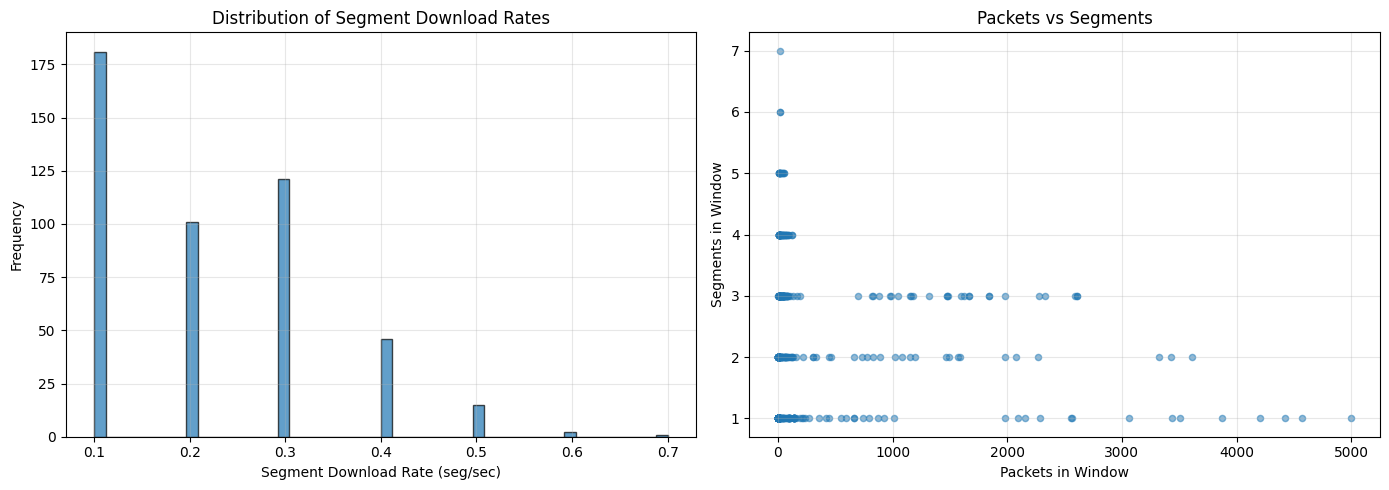


step 4 done

PART 1 COMPLETE
  - 467 samples, 27 features


In [91]:
print("="*80)
print("computing segment download rate")
print("="*80)



# count segments in a window
def identify_segments_in_window(packet_times, gap_threshold=1.0):
    if len(packet_times) < 2:
        return 1
    
    times = sorted(packet_times)
    
    segment_count = 1
    
    for i in range(1, len(times)):
        gap = times[i] - times[i-1]
        if gap >= gap_threshold:
            segment_count += 1
    
    return segment_count

print("computing segment rates...\n")

segment_rates = []

for flow_id, (flow_key, flow_packets) in enumerate(flows_dict.items()):
    if len(flow_packets) < 2:
        continue
    
    packet_times = [float(pkt.time) for pkt in flow_packets]
    packet_times.sort()
    
    start_time = packet_times[0]
    end_time = packet_times[-1]
    duration = end_time - start_time
    
    if duration < 1.0:
        continue
    
    window_size = 10.0
    current_time = start_time
    
    while current_time < end_time:
        window_end = current_time + window_size
        
        window_times = [t for t in packet_times 
                       if current_time <= t < window_end]
        
        if len(window_times) >= 2:
            num_segments = identify_segments_in_window(window_times, gap_threshold=1.0)
            
            segment_rates.append({
                'flow_id': flow_id,
                'window_start': current_time - start_time,
                'num_segments': num_segments,
                'segment_download_rate': num_segments / window_size
            })
        
        current_time = window_end

segment_df = pd.DataFrame(segment_rates)

print(f"computed segment rates for {len(segment_df)} windows")

# merge with existing features
print("\nmerging with features...")

features_df = features_df.merge(
    segment_df[['flow_id', 'window_start', 'num_segments', 'segment_download_rate']],
    on=['flow_id', 'window_start'],
    how='left'
)

features_df['num_segments'].fillna(0, inplace=True)
features_df['segment_download_rate'].fillna(0, inplace=True)

print(f"merged! total features: {len(features_df.columns)}")

print("\nsegment rate stats:")
print(features_df['segment_download_rate'].describe())

print("\nsample rows:")
print(features_df[['flow_id', 'window_start', '10_num_packets', 'num_segments', 
                   'segment_download_rate', '10_avg_chunksize']].head(10))

# visualize
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(features_df['segment_download_rate'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Segment Download Rate (seg/sec)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Segment Download Rates')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(features_df['10_num_packets'], features_df['num_segments'], alpha=0.5, s=20)
axes[1].set_xlabel('Packets in Window')
axes[1].set_ylabel('Segments in Window')
axes[1].set_title('Packets vs Segments')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('segment_analysis.png', dpi=150, bbox_inches='tight')
print("\nsaved visualization as segment_analysis.png")
plt.show()

print("\nstep 4 done")

print("\n" + "="*80)
print("PART 1 COMPLETE")
print(f"  - {len(features_df)} samples, {len(features_df.columns)} features")
print("="*80)

## Part 2: Video Quality Inference

You will now load the complete video dataset from a previous study to train and test models based on these features to automatically infer the quality of a streaming video flow.

For this part of the assignment, you will need two pickle files, which we provide for you by running the code below:

```

!gdown 'https://drive.google.com/uc?id=1N-Cf4dJ3fpak_AWgO05Fopq_XPYLVqdS' -O netflix_session.pkl
!gdown 'https://drive.google.com/uc?id=1PHvEID7My6VZXZveCpQYy3lMo9RvMNTI' -O video_dataset.pkl

```

### Load the File

Load the video dataset pickle file.

In [71]:
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, 
                            classification_report, roc_auc_score, roc_curve)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize

print("="*80)
print("PART 2: VIDEO QUALITY INFERENCE")
print("="*80)

print("\nloading dataset...")
with open('netflix_dataset.pkl', 'rb') as f:
    df = pickle.load(f)

print(f"loaded dataset: {df.shape}")

resolution_col = 'resolution'
print(f"\nresolution distribution (before cleaning):")
print(df[resolution_col].value_counts().sort_index())

PART 2: VIDEO QUALITY INFERENCE

loading dataset...
loaded dataset: (52279, 251)

resolution distribution (before cleaning):
resolution
0.000        2531
240.000      1701
360.000      4476
480.000     29486
720.000      9457
1080.000     4628
Name: count, dtype: int64


### Clean the File

1. The dataset contains video resolutions that are not valid. Remove entries in the dataset that do not contain a valid video resolution. Valid resolutions are 240, 360, 480, 720, 1080.

In [72]:
print("\n" + "="*80)
print("cleaning data...")
print("="*80)

valid_resolutions = [240, 360, 480, 720, 1080]

# filter valid resolutions only
df_clean = df[df[resolution_col].isin(valid_resolutions)].copy()

print(f"\nresolution distribution (after cleaning):")
print(df_clean[resolution_col].value_counts().sort_index())

print(f"\ncleaned: {df.shape} → {df_clean.shape}")
print(f"removed {len(df) - len(df_clean)} rows")


cleaning data...

resolution distribution (after cleaning):
resolution
240.000      1701
360.000      4476
480.000     29486
720.000      9457
1080.000     4628
Name: count, dtype: int64

cleaned: (52279, 251) → (49748, 251)
removed 2531 rows


2. The file also contains columns that are unnecessary (in fact, unhelpful!) for performing predictions. Identify those columns, and remove them.

In [73]:
print("\n" + "="*80)
print("removing unnecessary columns...")
print("="*80)

# cols to remove
columns_to_remove = [
    # IDs - cause overfitting
    'session_id', 'deployment_session_id', 'home_id', 'video_id',
    
    # time info - not generalizable
    'absolute_timestamp', 'relative_timestamp', 
    'chunk_start_time', 'chunk_end_time', 'video_position',
    
    # target leakage - reveals resolution
    'bitrate', 'previous_bitrate', 'quality',
    
    # metadata
    'index', 'service',
    
    # startup flags
    'startup3.3', 'startup6.6', 'startup5', 'startup10',
    
    # problematic type
    '10_EWMA_chunksizes',
]

cols_exist = [col for col in columns_to_remove if col in df_clean.columns]

print(f"\nremoving {len(cols_exist)} columns:")
for col in cols_exist:
    print(f"  - {col}")

df_clean = df_clean.drop(columns=cols_exist)

print(f"\nremaining columns: {df_clean.shape[1]}")


removing unnecessary columns...

removing 19 columns:
  - session_id
  - deployment_session_id
  - home_id
  - video_id
  - absolute_timestamp
  - relative_timestamp
  - chunk_start_time
  - chunk_end_time
  - video_position
  - bitrate
  - previous_bitrate
  - quality
  - index
  - service
  - startup3.3
  - startup6.6
  - startup5
  - startup10
  - 10_EWMA_chunksizes

remaining columns: 232


**Briefly explain why you removed those columns.**

A lot of columns like session_id and other id-like columns fall into the problem of overfitting. We must remove them because different sessions and users will have different quality we do not want the model to relate session ID with quality and then be confused when seeing different ID numbers, we want the model to only look at data related to quality of video not other general patterns. we must obviously remove bitrate from this because bitrate is just resolution if we know it is high then resolution is high, we have to remove it because we want to use network ideas like packets, chunks, etc to make inferences and not just have an obvious bitrate to resolution calculation, abstractly we cannot give the model the answer key to the test because then there is no point to taking the test. I also remove some irrelevant data like timestamps and chunk start and end times becaus eit may add some biass for us. if someone opens a video in the morning or evening, tuesday vs wednesday, it is meaningless to us to look at. taking things like video position for example will also be bad because we may run into overfitting again and make inferences based on if someone is earlier in the video or later. i.e. most people will click off videos in low res quicky, does that mean everyone in the start of the video will have low res? obviously not. I ended up removing 10_EWMA_chunksizes despite my previous answer because I ran into code issues with it and decided its better to remove than debug because we do not have to be perfect in our model training for this assignment but it is beter to keep. I also remove all startup because well we cannot deal with both starting video and steady video in the same way. i remember the professor mentioned in class that netflix preloads video so start up is fast and this will create bias in the data and we would want to deal with this case separately, i.e. use other model for startup but for this assignment we do not want to be confused with startup. I probabl could keep some of these in and it wouldnt introduce enough issues in the model especially because accuracy is not really tested but I thought to be more conservative with keeping features so I can get good model accuracy.

### Prepare Your Data

Prepare your data matrix, determine your features and labels, and perform a train-test split on your data.

In [86]:
print("\n" + "="*80)
print("removing unnecessary columns...")
print("="*80)

# cols to remove
columns_to_remove = [
    # IDs - cause overfitting
    'session_id', 'deployment_session_id', 'home_id', 'video_id',
    
    # time info - not generalizable
    'absolute_timestamp', 'relative_timestamp', 
    'chunk_start_time', 'chunk_end_time', 'video_position',
    
    # target leakage - reveals resolution
    'bitrate', 'previous_bitrate', 'quality',
    
    # metadata
    'index', 'service',
    
    # startup flags
    'startup3.3', 'startup6.6', 'startup5', 'startup10',
    
    # problematic type
    '10_EWMA_chunksizes',
]

cols_exist = [col for col in columns_to_remove if col in df_clean.columns]

print(f"\nremoving {len(cols_exist)} columns:")
for col in cols_exist:
    print(f"  - {col}")

df_clean = df_clean.drop(columns=cols_exist)

print(f"\nremaining columns: {df_clean.shape[1]}")


removing unnecessary columns...

removing 0 columns:

remaining columns: 232


In [85]:
print("\n" + "="*80)
print("preparing features and labels...")
print("="*80)

# separate X and y
X = df_clean.drop(columns=[resolution_col])
y = df_clean[resolution_col]

# remove non-numeric cols
non_numeric = X.select_dtypes(exclude=[np.number]).columns
if len(non_numeric) > 0:
    print(f"\nremoving {len(non_numeric)} non-numeric columns")
    X = X.drop(columns=non_numeric)

# handle NaN and inf
X = X.fillna(0)
X = X.replace([np.inf, -np.inf], 0)

print(f"\nfinal feature count: {X.shape[1]}")
print(f"\ntarget distribution:\n{y.value_counts().sort_index()}")

# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\ntrain/test split (80/20):")
print(f"  X_train: {X_train.shape}")
print(f"  X_test: {X_test.shape}")

# scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("\nfeatures scaled")


preparing features and labels...

removing 2 non-numeric columns

final feature count: 229

target distribution:
resolution
240.000      1701
360.000      4476
480.000     29486
720.000      9457
1080.000     4628
Name: count, dtype: int64

train/test split (80/20):
  X_train: (39798, 229)
  X_test: (9950, 229)

features scaled


### Train and Tune Your Model

1. Select a model of your choice.
2. Train the model using your training data.

In [84]:
print("\n" + "="*80)
print("training random forest...")
print("="*80)

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)
print("initial model trained")

# test accuracy
y_pred = rf_model.predict(X_test_scaled)
initial_accuracy = accuracy_score(y_test, y_pred)
print(f"initial accuracy: {initial_accuracy:.4f}")


training random forest...
initial model trained
initial accuracy: 0.9447


### Tune Your Model

Perform hyperparameter tuning to find optimal parameters for your model.

In [87]:
print("\n" + "="*80)
print("[Step 6] Hyperparameter tuning...")
print("="*80)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [15, 20, 25],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

print("Running GridSearchCV (this may take a few minutes)...")
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print(f"\n✓ Best parameters: {grid_search.best_params_}")
print(f"✓ Best CV score: {grid_search.best_score_:.4f}")

# Use best model
best_model = grid_search.best_estimator_


[Step 6] Hyperparameter tuning...
Running GridSearchCV (this may take a few minutes)...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

✓ Best parameters: {'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
✓ Best CV score: 0.9404


### Evaluate Your Model

Evaluate your model accuracy according to the following metrics:

1. Accuracy
2. F1 Score
3. Confusion Matrix
4. ROC/AUC


evaluating model...

1. Accuracy: 0.9473

2. F1 Score:
   macro: 0.8911
   weighted: 0.9456

3. Confusion Matrix:
[[ 206   36   82   16    0]
 [  23  743  121    8    0]
 [  19   30 5813   33    2]
 [   6    4  113 1746   23]
 [   0    0    0    8  918]]

saved confusion_matrix.png


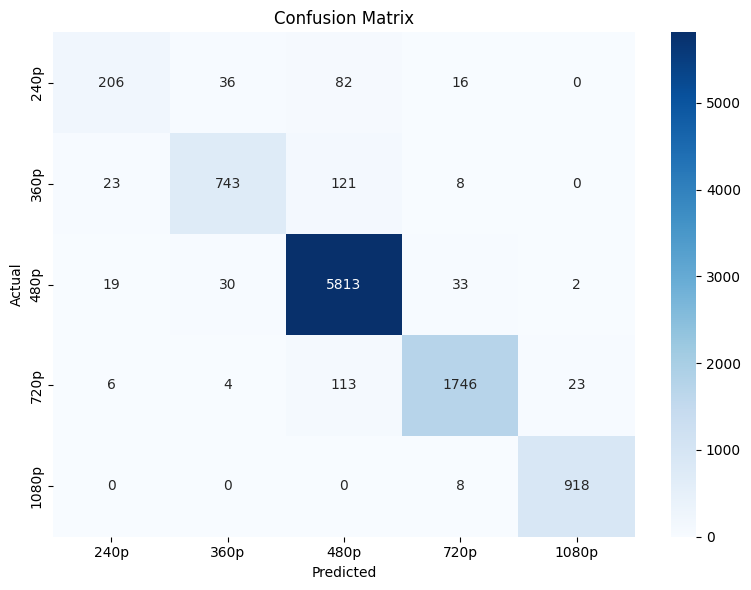


Classification Report:
              precision    recall  f1-score   support

        240p       0.81      0.61      0.69       340
        360p       0.91      0.83      0.87       895
        480p       0.95      0.99      0.97      5897
        720p       0.96      0.92      0.94      1892
       1080p       0.97      0.99      0.98       926

    accuracy                           0.95      9950
   macro avg       0.92      0.87      0.89      9950
weighted avg       0.95      0.95      0.95      9950


4. ROC/AUC:
classes: ['240p', '360p', '480p', '720p', '1080p']
  240p: AUC = 0.9899
  360p: AUC = 0.9906
  480p: AUC = 0.9944
  720p: AUC = 0.9967
  1080p: AUC = 0.9998

saved roc_curves.png


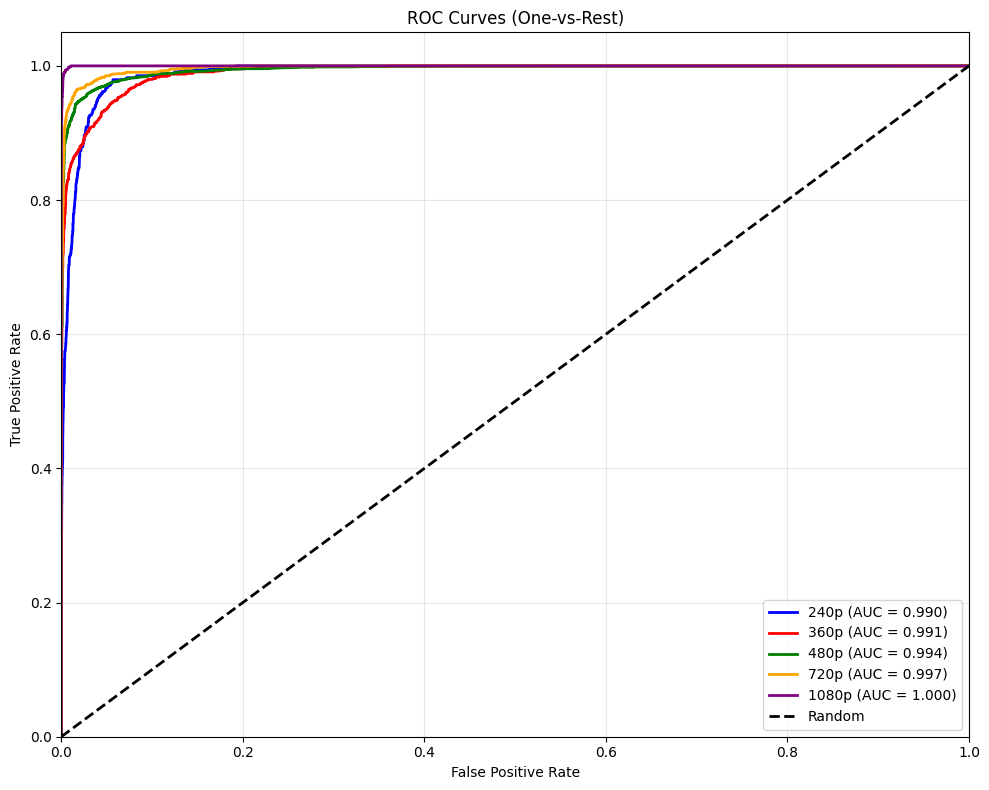


macro-avg AUC: 0.9943
weighted-avg AUC: 0.9948

step 7 done


In [82]:
print("\n" + "="*80)
print("evaluating model...")
print("="*80)

y_pred = best_model.predict(X_test_scaled)

# 1. accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\n1. Accuracy: {accuracy:.4f}")

# 2. F1 score
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
print(f"\n2. F1 Score:")
print(f"   macro: {f1_macro:.4f}")
print(f"   weighted: {f1_weighted:.4f}")

# 3. confusion matrix
print(f"\n3. Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['240p', '360p', '480p', '720p', '1080p'],
            yticklabels=['240p', '360p', '480p', '720p', '1080p'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150)
print("\nsaved confusion_matrix.png")
plt.show()

# classification report
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, 
                          target_names=['240p', '360p', '480p', '720p', '1080p']))

# 4. ROC/AUC
print(f"\n4. ROC/AUC:")

from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc

y_pred_proba = best_model.predict_proba(X_test_scaled)

classes = sorted(y.unique())
class_labels = [f'{int(c)}p' for c in classes]

print(f"classes: {class_labels}")

# binarize labels
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = len(classes)

# ROC curve per class
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))

colors = ['blue', 'red', 'green', 'orange', 'purple']

for i, (cls, color) in enumerate(zip(classes, colors)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_labels[i]} (AUC = {roc_auc[i]:.3f})')
    
    print(f"  {class_labels[i]}: AUC = {roc_auc[i]:.4f}")

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves.png', dpi=300)
print("\nsaved roc_curves.png")
plt.show()

# macro and weighted AUC
macro_auc = roc_auc_score(y_test_bin, y_pred_proba, multi_class='ovr', average='macro')
print(f"\nmacro-avg AUC: {macro_auc:.4f}")

weighted_auc = roc_auc_score(y_test_bin, y_pred_proba, multi_class='ovr', average='weighted')
print(f"weighted-avg AUC: {weighted_auc:.4f}")

print("\nstep 7 done")

General summary and evaluation: extra for me
why use random forest model? well it has low overfitting risk and we have a lot of data like packet ata, chunk data, timing data and random forest is good at handling the mix effectively. It also does not overengineer the issue. Lookina at the performance data we see that our model was very accurate at inference and it showed 94.7% accuracy and D1 of 0.946. This is very good to see seeing we only read encyrpted traffic. I find though that low res is harder to classify and has lower f score possibly because in the data set they are less prevelant in the samples the more you go down in resolution. ROC score is all excellent and this shows we can predict traffic signature reallt well.

## Part 3: Predict the Ongoing Resolution of a Real Netflix Session

Now that you have your model, it's time to put it in practice!

Use a preprocessed Netflix video session to infer **and plot** the resolution at 10-second time intervals.


PART 3: predicting resolution for one session

analyzing test set...

selected session:
  samples: 50
  duration: 500 sec (~8.3 min)

making predictions...
predicted 50 values

saved part3_session_predictions.png


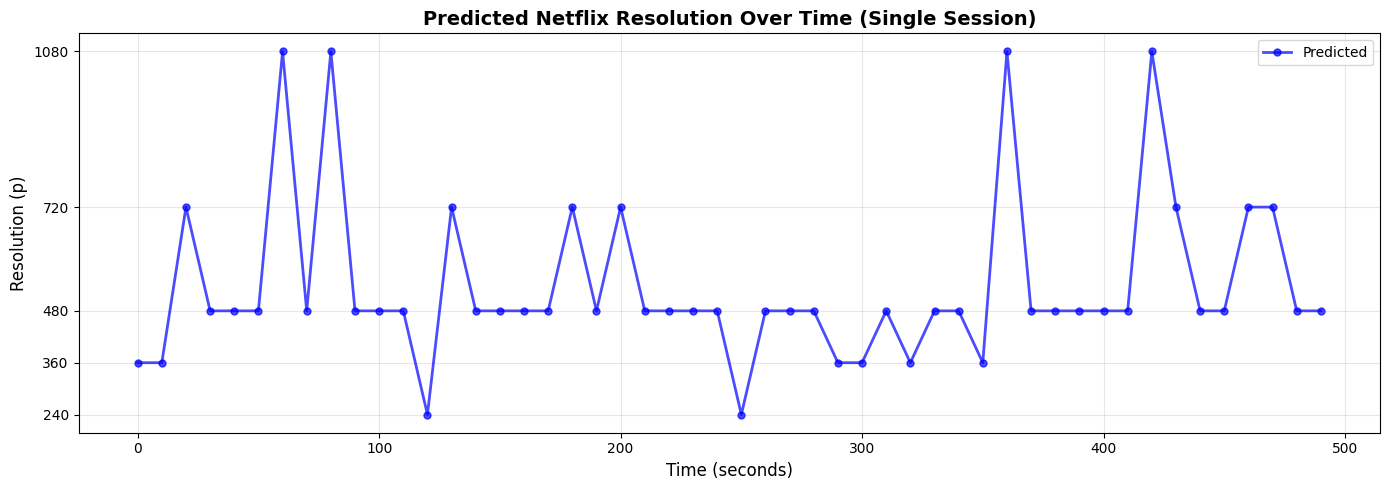

saved part3_session_comparison.png


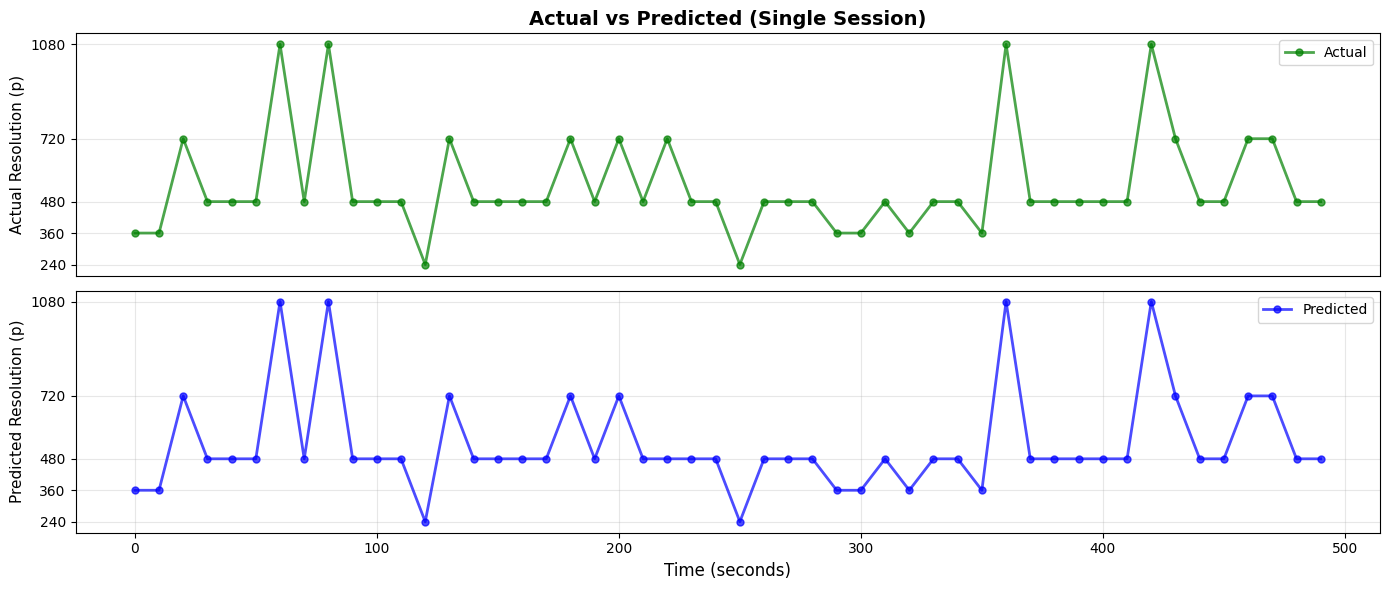


session stats

session accuracy: 98.00%

actual distribution:
  240p:  2 samples (  4.0%)
  360p:  6 samples ( 12.0%)
  480p: 30 samples ( 60.0%)
  720p:  8 samples ( 16.0%)
  1080p:  4 samples (  8.0%)

predicted distribution:
  240p:  2 samples (  4.0%)
  360p:  6 samples ( 12.0%)
  480p: 31 samples ( 62.0%)
  720p:  7 samples ( 14.0%)
  1080p:  4 samples (  8.0%)

detailed predictions
Time (s)   Actual     Predicted  Correct?  
--------------------------------------------------
0          360        360        ✓         
10         360        360        ✓         
20         720        720        ✓         
30         480        480        ✓         
40         480        480        ✓         
50         480        480        ✓         
60         1080       1080       ✓         
70         480        480        ✓         
80         1080       1080       ✓         
90         480        480        ✓         
100        480        480        ✓         
110        480        480    

In [ ]:
print("\n" + "="*80)
print("PART 3: predicting resolution for one session")
print("="*80)

# test set has multiple sessions - just pick one
print("\nanalyzing test set...")

# no session_id anymore so just grab consecutive samples
# 50 samples = 500 sec = ~8 min video

session_length = 50
session_start = 0  # start from beginning

# grab session data
X_session = X_test_scaled[session_start:session_start + session_length]
y_session = y_test.iloc[session_start:session_start + session_length]

print(f"\nselected session:")
print(f"  samples: {len(X_session)}")
print(f"  duration: {len(X_session) * 10} sec (~{len(X_session) * 10 / 60:.1f} min)")

# predict on this session
print("\nmaking predictions...")
y_pred_session = best_model.predict(X_session)

print(f"predicted {len(y_pred_session)} values")

# time axis (10-sec intervals)
time_seconds = np.arange(0, len(y_pred_session) * 10, 10)

# plot predictions only
plt.figure(figsize=(14, 5))
plt.plot(time_seconds, y_pred_session, marker='o', linewidth=2, markersize=5, 
         alpha=0.7, color='blue', label='Predicted')
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Resolution (p)', fontsize=12)
plt.title('Predicted Netflix Resolution Over Time (Single Session)', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.yticks([240, 360, 480, 720, 1080])
plt.legend()
plt.tight_layout()
plt.savefig('part3_session_predictions.png', dpi=150)
print("\nsaved part3_session_predictions.png")
plt.show()

# actual vs predicted
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(time_seconds, y_session.values, marker='o', linewidth=2, markersize=5, 
         alpha=0.7, color='green', label='Actual')
plt.ylabel('Actual Resolution (p)', fontsize=11)
plt.title('Actual vs Predicted (Single Session)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.yticks([240, 360, 480, 720, 1080])
plt.legend()
plt.xticks([])

plt.subplot(2, 1, 2)
plt.plot(time_seconds, y_pred_session, marker='o', linewidth=2, markersize=5, 
         alpha=0.7, color='blue', label='Predicted')
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Predicted Resolution (p)', fontsize=11)
plt.grid(True, alpha=0.3)
plt.yticks([240, 360, 480, 720, 1080])
plt.legend()

plt.tight_layout()
plt.savefig('part3_session_comparison.png', dpi=150)
print("saved part3_session_comparison.png")
plt.show()

# session stats
print("\n" + "="*80)
print("session stats")
print("="*80)

# accuracy for this session
session_accuracy = accuracy_score(y_session, y_pred_session)
print(f"\nsession accuracy: {session_accuracy:.2%}")

# resolution breakdown
print("\nactual distribution:")
for res in sorted(y_session.unique()):
    count = (y_session == res).sum()
    pct = count / len(y_session) * 100
    print(f"  {int(res)}p: {count:2d} samples ({pct:5.1f}%)")

print("\npredicted distribution:")
for res in sorted(np.unique(y_pred_session)):
    count = (y_pred_session == res).sum()
    pct = count / len(y_pred_session) * 100
    print(f"  {int(res)}p: {count:2d} samples ({pct:5.1f}%)")

# detailed table
print("\n" + "="*80)
print("detailed predictions")
print("="*80)
print(f"{'Time (s)':<10} {'Actual':<10} {'Predicted':<10} {'Correct?':<10}")
print("-" * 50)
for i in range(len(y_session)):
    actual = int(y_session.iloc[i])
    predicted = int(y_pred_session[i])
    correct = "✓" if actual == predicted else "✗"
    print(f"{i*10:<10} {actual:<10} {predicted:<10} {correct:<10}")

print("\n" + "="*80)
print("PART 3 DONE")
print("="*80)
print("\nshows model performance on one viewing session")
print("in practice ISPs would use this for real-time monitoring")
print("tracking quality changes as they happen")

General conclusion, extra just for me:

Looking at the graph above, wow what a match save for one peak that our model missed. So I now know we can use simply just packey capture to get meaningful feature and information without getting encrypted data. We select good features important for us and remove ones that will cause overfitting and noise and random forest is good at dealing with lots of features. We can monitor streaming quality without having the encrypted data. Model struggles a little when we switch resoluton and this shows its a little hard to predict unpredictable traffic without getting this direct data but dare I say it feels like it is good enough for most purposes!